In [1]:
import jax
import jax.numpy as jnp
from jax.config import config
from gdml_jax.util.datasets import load_md17
from gdml_jax.kernels import GDMLKernel
from gdml_jax.models import GDMLPredict, GDMLPredictEnergy
from gdml_jax.solve import solve_closed
from gdml_jax import losses

# enable double precision
config.update("jax_enable_x64", True)

# args
DATA_DIR = "/tmp/md17"
MOLECULE = "ethanol"
N_TRAIN = 100
N_TEST = 200
LENGTHSCALE = 10.
REG = 1e-10

# data loading
trainset, testset, meta = load_md17(MOLECULE, N_TRAIN, N_TEST, DATA_DIR)
train_x, train_e, train_f = trainset
shape = meta["shape"]

# define basekernel and model
basekernel = GDMLKernel(shape)
kernel_kwargs = {"lengthscale": LENGTHSCALE}

# solve in closed form
params = solve_closed(basekernel, train_x, train_f, reg=REG, kernel_kwargs=kernel_kwargs)

In [15]:
jax.tree_map(jnp.shape, params)

{'alpha': (100, 9, 3), 'kernel_kwargs': {'lengthscale': ()}}

In [3]:
test_x, test_e, test_f = testset
force_fn = GDMLPredict(basekernel, train_x)
preds_f = force_fn(params, test_x)
print("forces:")
print(f"test MSE: {losses.mse(test_f, preds_f)}")
print(f"test MAE: {losses.mae(test_f, preds_f)}")

energy_fn = GDMLPredictEnergy(basekernel, train_x, train_e, params)
preds_e = energy_fn(test_x)
print("energies:")
print(f"test MSE: {losses.mse(test_e, preds_e)}")
print(f"test MAE: {losses.mae(test_e, preds_e)}")

forces:
test MSE: 9.197358087402225
test MAE: 2.1646725437465406
energies:
test MSE: 0.7140331023730744
test MAE: 0.6558248631077731


## Inspecting the sgdml kernelmatrix manually

In [9]:
from gdml_jax.solve import dkernelmatrix

K = dkernelmatrix(basekernel, train_x[:2], train_x[:2], kernel_kwargs=kernel_kwargs, flatten=False)
K.shape

(2, 2, 9, 3, 9, 3)

In [10]:
K_flat = dkernelmatrix(basekernel, train_x[:2], train_x[:2], kernel_kwargs=kernel_kwargs, flatten=True)
K_flat.shape

(54, 54)

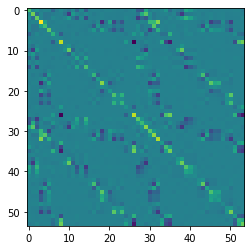

In [13]:
import matplotlib.pyplot as plt
plt.imshow(K_flat)